## Polarimetry Experiment
Objective: To measure the linear polarization of an LED source. The experiment entails to find the two parameters which define linear polarization - $p$ and $\theta$, which are in turn obtained from the normalized Stokes parameters $q$ and $u$. Aperture photometry is to be performed, and the parameters are to be found over different runs.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry
from photutils import CircularAperture, CircularAnnulus

In [2]:
from astropy.io import fits
from astropy.visualization import simple_norm
import tensorflow as tf


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Give me the algo.
The algorithm is as follows:
1. First, we need to load the image using `astropy.io.fits`.
2. Then, visualize it. Left side image corresponds to `i` beam and right side to `e` beam. 
3. Now, we need to find the centers of the two Gaussians (or approximate Gaussians). This, we find by dividing the image into two (exploit symmetry of the system), and find the point of max intensity.
4. Obtain the FWHM by finding the location having pixel value closest to FWHM. For this, use the vertical slice running through the maximum.
5. Radius of disc is defined as distance between 3FWHM pixel and center pixel.
6. 4x FWHM and 6x FWHM define the radii of the annulus.
7. Obtain the sky subtracted pixel values.
8. Save these values to perform computation to obtain `q`,`u`,`p`,and $\theta$ parameters.

#### First visualize one image.

In [3]:
def nearest_neigh(x,val):
    ''' Function to define the L2 norm and find nearest neighbour '''
    l2=np.square(x-val)
    minval=np.min(l2)
    return [np.where(l2==minval),minval]

(512, 512)
SIMPLE  =                    T /                                                BITPIX  =                   16 /                                                NAXIS   =                    2 /                                                NAXIS1  =                  512 /                                                NAXIS2  =                  512 /                                                OBJECT  = '        '           /                                                TELESCOP= 'Unknown Telescope'                                                   INSTRUME= 'SBIG ST-9'                                                           OBSERVER= 'Observer's Name'                                                     DATE-OBS= '2019-02-06T14:02:04.000' / GMT START OF EXPOSURE [WIN]               BZERO   = +3.276800000000E+004 /                                                BSCALE  = +1.000000000000E+000 /                                                EXPTIME = +1.200000000000E-00

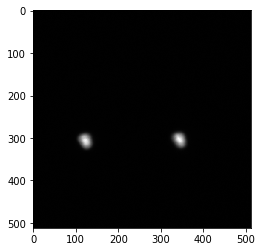

In [4]:
path = 'Team6/run1_0.FIT'
hdulist=fits.open(path)
data=hdulist[0].data
print data.shape
print hdulist[0].header
plt.imshow(data,cmap='gray')
#plt.savefig('Rep_img.eps',fmt='eps',dpi=300)

(array([306]), array([123])) (array([302]), array([341]))
10403
(array([293]),)


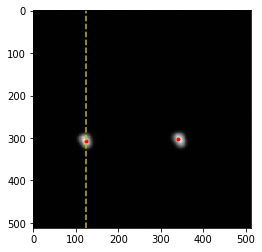

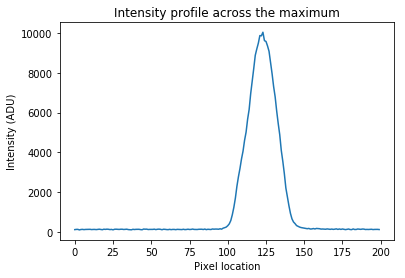

In [5]:
leftdat=data[:,:200]
maxin=np.max(leftdat)
g1=np.where(data==maxin)
rightdat=data[:,200:]
maxin=np.max(rightdat)
g2=np.where(data==maxin)
print g1,g2
print maxin
plt.imshow(data,cmap='gray')
plt.plot([g1[1][0],g2[1][0]],[g1[0][0],g2[0][0]],'r.')
plt.axvline(x=123,color='y',linestyle='--')
#plt.savefig('Max.eps',fmt='eps',dpi=300)
plt.figure()
plt.plot(data[306,:200])
plt.xlabel('Pixel location')
plt.ylabel('Intensity (ADU)')
plt.title('Intensity profile across the maximum')
#plt.savefig('Gauss.eps',fmt='eps',dpi=300)
fullmax=np.max(data[306,:200])
loc,err = nearest_neigh(data[:,123],fullmax/2.0)
print loc
#These are centers of the gaussians

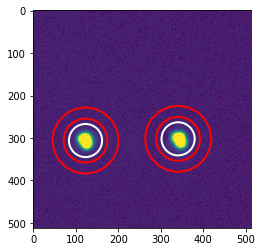

In [6]:
positions=[(g1[1][0],g1[0][0]),(g2[1][0],g2[0][0])]
fwhm = np.abs(loc[0][0]-g1[0][0])
apertures = CircularAperture(positions, r=3.0*fwhm)
annulus_apertures = CircularAnnulus(positions, r_in=fwhm*4.0, r_out=fwhm*6.0)
annulus_masks = annulus_apertures.to_mask(method='center')
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm)
apertures.plot(color='white', lw=2)
annulus_apertures.plot(color='red', lw=2)
#plt.savefig('Annulus.eps',fmt='eps',dpi=300)

In [7]:
bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area()
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output
print(phot)

 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                                                        
--- ------- ------- ------------ -------------- --------- ---------------
  1     123     306    6212392.2            122 582960.22         5629432
  2     341     302    6171785.5            120 573403.49         5598382


#### Now starts automation

In [8]:
def get_params(data):
    '''
        This function takes in the fits file, and generates the center and the FWHM of the beams.
        Input: Polarimetry image.
        Output: list(center1,center2, FWHM of the brightest beam)
    '''
    size = data.shape[1]
    leftdat=data[:,:size/2]
    maxin=np.max(leftdat)
    g1=np.where(data==maxin)
    rightdat=data[:,size/2:]
    maxin=np.max(rightdat)
    g2=np.where(data==maxin)
    print g1,g2
    print maxin
    if np.max(data[306,:size/2])>np.max(data[306,size/2:]):
        fullmax = np.max(data[306,:size/2])
        loc,err = nearest_neigh(data[:,g1[1][0]],fullmax/2.0)
        fwhm = np.abs(loc[0][0]-g1[0][0])
    else:
        fullmax = np.max(data[306,size/2:])
        loc,err = nearest_neigh(data[:,g2[1][0]],fullmax/2.0)
        fwhm = np.abs(loc[0][0]-g2[0][0])
    return [[(g1[1][0],g1[0][0]),(g2[1][0],g2[0][0])],fwhm]

In [9]:
'''
    Here starts what is known as a tensorflow graph. Essentially, the independent parameters 
    are defined as placeholders, which can be passed data in the form of a dictionary.
    The other parameters, in our case, are defined as mappings between these independent parameters.
    
    If we need to find a mapped value corresponding to a set of independent values, we evaluate
    this parameter in a Tensorflow session. Thus, we can obtain q,u,p and theta by evaluating them
    in a session.
    
    To find out the errors, we need the partial derivatives. Tensorflow gives us these gradients
    once the mapping is defined, so it is just a function call to evaluate the gradients.

'''
tf.reset_default_graph() #Always a good practise to reset the graph for different evaluations.
n0 = tf.placeholder(tf.float32) #no ==> I_0
n1 = tf.placeholder(tf.float32) #n1 ==> I_90
n2 = tf.placeholder(tf.float32) #n2 ==> I_45
n3 = tf.placeholder(tf.float32) #n3 ==> I_135
sig_n0 = tf.placeholder(tf.float32) #Corresponding sigmas
sig_n1 = tf.placeholder(tf.float32)
sig_n2 = tf.placeholder(tf.float32)
sig_n3 = tf.placeholder(tf.float32)
q_tens = (n1-n0)/(n0+n1) #Defining the Stokes parameters.
u_tens = (n3-n2)/(n3+n2)
p_tens = tf.sqrt(tf.square(q_tens)+tf.square(u_tens)) #Polarization fraction
theta_tens = 0.5*tf.atan(u_tens/q_tens) #Angle of polarization
#We use the chain rule: sigma_f = Sum over all x [((df/dx)*sigma_x)^2]

sig_p = tf.square(tf.gradients(p_tens,n0)*sig_n0)+tf.square(tf.gradients(p_tens,n1)*sig_n1)
sig_p = sig_p+tf.square(tf.gradients(p_tens,n2)*sig_n2)+tf.square(tf.gradients(p_tens,n3)*sig_n3)
sig_theta = tf.square(tf.gradients(theta_tens,n0)*sig_n0)+tf.square(tf.gradients(theta_tens,n1)*sig_n1)
sig_theta = sig_theta+tf.square(tf.gradients(theta_tens,n2)*sig_n2)+tf.square(tf.gradients(theta_tens,n3)*sig_n3)
sig_q = tf.square(tf.gradients(q_tens,n0)*sig_n0)+tf.square(tf.gradients(q_tens,n1)*sig_n1)
sig_u = tf.square(tf.gradients(u_tens,n2)*sig_n2)+tf.square(tf.gradients(u_tens,n3)*sig_n3)

sig_p = tf.sqrt(sig_p)
sig_q = tf.sqrt(sig_q)
sig_u = tf.sqrt(sig_u)
sig_theta = tf.sqrt(sig_theta)
sess=tf.Session()

(array([306]), array([123])) (array([302]), array([341]))
10403
 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                                                        
--- ------- ------- ------------ -------------- --------- ---------------
  1     123     306    6212392.2            122 582960.22         5629432
  2     341     302    6171785.5            120 573403.49         5598382
(array([303]), array([121])) (array([301]), array([342]))
10308
 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                                                        
--- ------- ------- ------------ -------------- --------- ---------------
  1     121     303    6529056.6            121 578181.85       5950874.8
  2     342     301    6432885.9            120 573403.49       5859482.4
(array([297]), array([124])) (array([295]), array([344]))
10740
 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_b

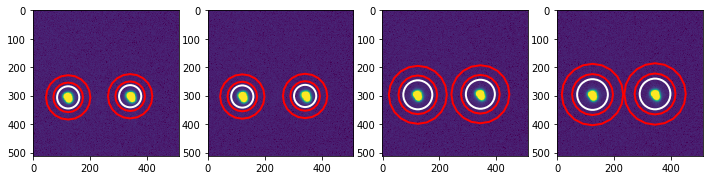

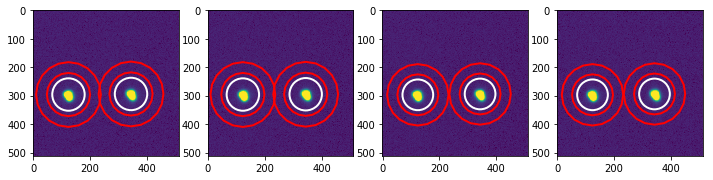

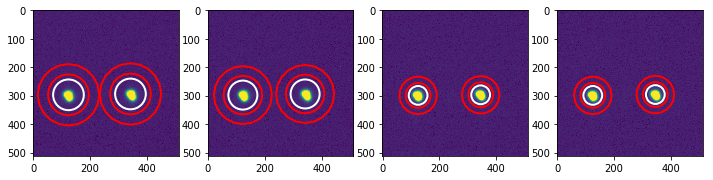

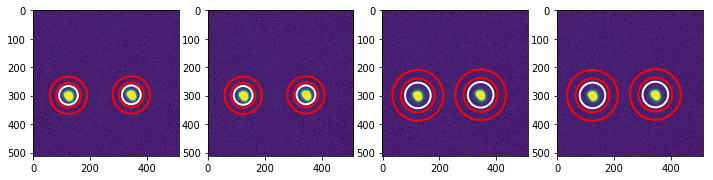

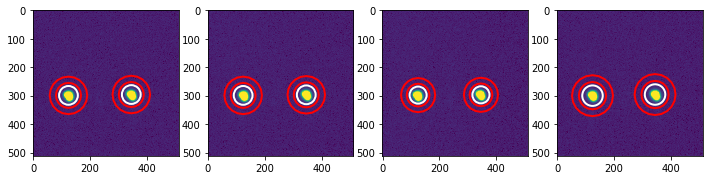

In [11]:
Io_total={'data':[],'error':[]}
Ie_total={'data':[],'error':[]}
q_total={'data':[],'error':[]}
u_total={'data':[],'error':[]}
p_total={'data':[],'error':[]}
theta_total={'data':[],'error':[]}
gain = 2.8
for runs in [1,2,3,4,5]:
    Io=[]
    Ie=[]
    plt.figure(figsize=(12,8))
    ptr=1
    for angles in [0,225,45,675]:
        path = 'Team6/run'+str(runs)+'_'+str(angles)+'.FIT' #Load data
        hdulist=fits.open(path)
        data=hdulist[0].data
        positions,fwhm=get_params(data) #Get centers, FWHM
        apertures = CircularAperture(positions, r=3.0*fwhm)
        annulus_apertures = CircularAnnulus(positions, r_in=4*fwhm, r_out=6*fwhm)
        annulus_masks = annulus_apertures.to_mask(method='center')
        norm = simple_norm(data, 'sqrt', percent=99)
        plt.subplot(1,4,ptr)
        ptr = ptr+1
        plt.imshow(data, norm=norm)
        apertures.plot(color='white', lw=2)
        annulus_apertures.plot(color='red', lw=2)
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_sigclip)
        bkg_median = np.array(bkg_median)
        phot = aperture_photometry(data, apertures)
        phot['annulus_median'] = bkg_median
        phot['aper_bkg'] = bkg_median * apertures.area()
        phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
        Io.append(phot['aper_sum_bkgsub'][0])
        Ie.append(phot['aper_sum_bkgsub'][1])
        for col in phot.colnames:
            phot[col].info.format = '%.8g'  # for consistent table output
        print(phot)
    Io=np.asarray(Io)*gain #Get the electrons
    Ie=np.asarray(Ie)*gain
    F=np.power(np.prod(Io)/np.prod(Ie),1/4.0)
    print "F value: %.4E"%F
    Ie_corrected=F*Ie
    Io_total['data'].append(Io)
    Ie_total['data'].append(Ie_corrected)
    Io_total['error'].append(np.sqrt(Io))
    Ie_total['error'].append(np.sqrt(Ie_corrected))
    # We have thus obtained the intensities.
    
    dict_feed={n0:Io_total['data'][-1][0],n1:Ie_total['data'][-1][0]}
    dict_feed[n2] = Io_total['data'][-1][1]
    dict_feed[n3] = Ie_total['data'][-1][1]
    dict_feed[sig_n3] = Ie_total['error'][-1][1]
    dict_feed[sig_n2] = Io_total['error'][-1][1]
    dict_feed[sig_n1] = Ie_total['error'][-1][0]
    dict_feed[sig_n0] = Io_total['error'][-1][0]
    #Dictionary to be fed in has been defined.
    
    q_total['error'].append(sess.run(sig_q,feed_dict=dict_feed))
    u_total['error'].append(sess.run(sig_u,feed_dict=dict_feed))
    p_total['error'].append(sess.run(sig_p,feed_dict=dict_feed))
    theta_total['error'].append(sess.run(sig_theta,feed_dict=dict_feed))
    #Obtained all the errors.
    
    q_total['data'].append(sess.run(q_tens,feed_dict=dict_feed))
    u_total['data'].append(sess.run(u_tens,feed_dict=dict_feed))
    p_total['data'].append(sess.run(p_tens,feed_dict=dict_feed))
    theta_total['data'].append(sess.run(theta_tens,feed_dict=dict_feed))
    #Obtained all the values.
    
    print "-------------------"
    print "Stokes parameters"
    print "-------------------"
    print "q: " + str(q_total['data'][-1]),
    print "   u: " + str(u_total['data'][-1])
    print "p: " + str(p_total['data'][-1]),
    print "   theta: "+ str(theta_total['data'][-1])
    print "----------------*****************-----------------------"

In [12]:
#Printing data to be copied easily to Latex:
for i in xrange(len(q_total['data'])):
    print str(i+1)+'&',
    print np.format_float_scientific(q_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(q_total['error'][i],precision=4,exp_digits=1)+'&',
    print np.format_float_scientific(u_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(u_total['error'][i],precision=4,exp_digits=1)+'&',
    print np.format_float_scientific(p_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(p_total['error'][i],precision=4,exp_digits=1)+'&',
    print np.format_float_scientific(theta_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(theta_total['error'][i],precision=4,exp_digits=1)+'&',
    print ""

1& 1.1388e-3$\pm$1.7800e-4& -3.8342e-3$\pm$1.7356e-4& 3.9997e-3$\pm$1.7392e-4& -6.4104e-1$\pm$2.2207e-2& 
2& 6.044e-3$\pm$1.7340e-4& -5.0584e-3$\pm$1.7031e-4& 7.8814e-3$\pm$1.7213e-4& -3.4843e-1$\pm$1.0886e-2& 
3& 5.2972e-3$\pm$1.7217e-4& -1.5050e-3$\pm$1.7400e-4& 5.5069e-3$\pm$1.7231e-4& -1.3841e-1$\pm$1.5786e-2& 
4& -2.2314e-3$\pm$1.7905e-4& -2.8223e-3$\pm$1.8081e-4& 3.5978e-3$\pm$1.8014e-4& 4.5090e-1$\pm$2.4978e-2& 
5& 3.6397e-3$\pm$1.7807e-4& 6.4757e-4$\pm$1.7880e-4& 3.6968e-3$\pm$1.781e-4& 8.8038e-2$\pm$2.4180e-2& 


In [13]:
#Printing data to be copied easily to Latex:
for i in xrange(len(u_total['data'])):
    print str(i+1)+'&',
    print np.format_float_scientific(q_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(q_total['error'][i],precision=4,exp_digits=1)+'&',
    print np.format_float_scientific(u_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(u_total['error'][i],precision=4,exp_digits=1)+'&',
    print np.format_float_scientific(p_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(p_total['error'][i],precision=4,exp_digits=1)+'&',
    print np.format_float_scientific(theta_total['data'][i],precision=4,exp_digits=1)+'$\pm$'+np.format_float_scientific(theta_total['error'][i],precision=4,exp_digits=1)+'&',
    print ""

1& 1.1388e-3$\pm$1.7800e-4& -3.8342e-3$\pm$1.7356e-4& 3.9997e-3$\pm$1.7392e-4& -6.4104e-1$\pm$2.2207e-2& 
2& 6.044e-3$\pm$1.7340e-4& -5.0584e-3$\pm$1.7031e-4& 7.8814e-3$\pm$1.7213e-4& -3.4843e-1$\pm$1.0886e-2& 
3& 5.2972e-3$\pm$1.7217e-4& -1.5050e-3$\pm$1.7400e-4& 5.5069e-3$\pm$1.7231e-4& -1.3841e-1$\pm$1.5786e-2& 
4& -2.2314e-3$\pm$1.7905e-4& -2.8223e-3$\pm$1.8081e-4& 3.5978e-3$\pm$1.8014e-4& 4.5090e-1$\pm$2.4978e-2& 
5& 3.6397e-3$\pm$1.7807e-4& 6.4757e-4$\pm$1.7880e-4& 3.6968e-3$\pm$1.781e-4& 8.8038e-2$\pm$2.4180e-2& 
